## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from unet import unet
from utils.dataset_utils import load_dataset_split, load_images_from_list
from utils.preprocessing import crop_image, merge_patches
from utils.vis_utils import plot_image_mask_prediction, plot_train_val, grid_vis

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
PLAYGROUND_DATASET_PATH = '../datasets/playground'
ICOSEG_SUBSET_80_PATH = '../datasets/icoseg/subset_80'
CHECKPOINTS_PATH = '../checkpoints'

In [5]:
!rm -rf $CHECKPOINTS_PATH
!mkdir $CHECKPOINTS_PATH

## 2. Load the dataset splits

In [6]:
train_images, train_masks, train_img_names = load_dataset_split(ICOSEG_SUBSET_80_PATH, 'train')
val_images, val_masks, val_img_names = load_dataset_split(ICOSEG_SUBSET_80_PATH, 'val')
test_images, test_masks, test_img_names = load_dataset_split(ICOSEG_SUBSET_80_PATH, 'test')

train_masks = train_masks[..., np.newaxis]
val_masks = val_masks[..., np.newaxis]
test_masks = test_masks[..., np.newaxis]

print(train_images.shape, train_images.dtype, train_images.min(), train_images.max())
print(val_images.shape, val_images.dtype, val_images.min(), val_images.max())

(50, 512, 512, 3) float64 0.0 1.0
(10, 512, 512, 3) float64 0.0 1.0


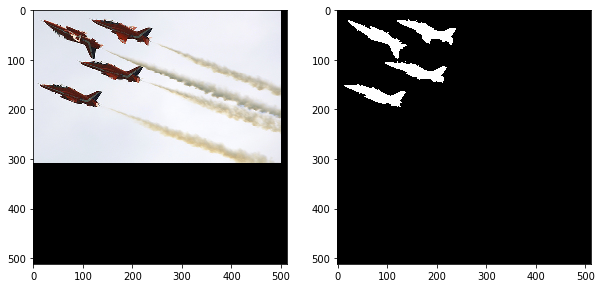

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[1])
plt.subplot(1, 2, 2)
plt.imshow(train_masks[1].squeeze(), cmap='gray')
plt.show()

## 3. Instantiate a U-Net

In [8]:
model = unet(input_shape=config.INPUT_SHAPE)

## 4. Train the model

In [9]:
%%time
model_checkpoint = ModelCheckpoint(f'{CHECKPOINTS_PATH}/unet_icoseg_test.hdf5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

model.fit(x=train_images, y=train_masks,
          validation_data=[val_images, val_masks],
          batch_size=config.BATCH_SIZE,
          epochs=config.NUM_EPOCHS,
          callbacks=[model_checkpoint])

Train on 50 samples, validate on 10 samples
Epoch 1/25
50/50 [==============================] - 63s 1s/step - loss: 0.3823 - acc: 0.9039 - tf_jaccard: 0.2185 - tf_dice: 0.3156 - val_loss: 0.1744 - val_acc: 0.9281 - val_tf_jaccard: 0.3379 - val_tf_dice: 0.4848

Epoch 00001: val_loss improved from inf to 0.17445, saving model to ../checkpoints/unet_icoseg_test.hdf5
Epoch 2/25
50/50 [==============================] - 50s 999ms/step - loss: 0.1822 - acc: 0.9169 - tf_jaccard: 0.4044 - tf_dice: 0.5664 - val_loss: 0.1380 - val_acc: 0.9673 - val_tf_jaccard: 0.4507 - val_tf_dice: 0.6043

Epoch 00002: val_loss improved from 0.17445 to 0.13799, saving model to ../checkpoints/unet_icoseg_test.hdf5
Epoch 3/25
50/50 [==============================] - 50s 1s/step - loss: 0.1721 - acc: 0.9205 - tf_jaccard: 0.4326 - tf_dice: 0.5997 - val_loss: 0.0991 - val_acc: 0.9483 - val_tf_jaccard: 0.4161 - val_tf_dice: 0.5685

Epoch 00003: val_loss improved from 0.13799 to 0.09915, saving model to ../checkpoints/u

In [10]:
print(dir(model.history))
#print(model.history.history)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']


### Some plots
__Remember:__
1. we use patches (not initial images) for the training part;
2. accuracy is not a good metric for image segmentation evaluation (patches with small objects can have good accuracies with zero prediction for all pixels).

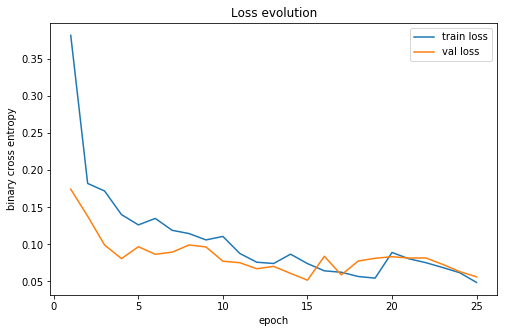

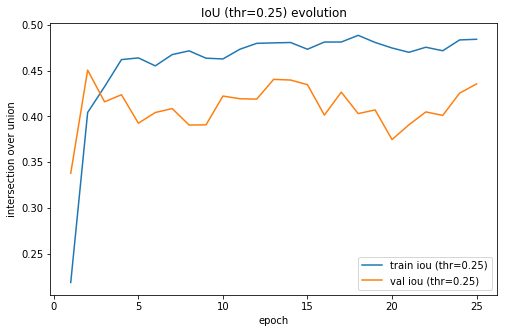

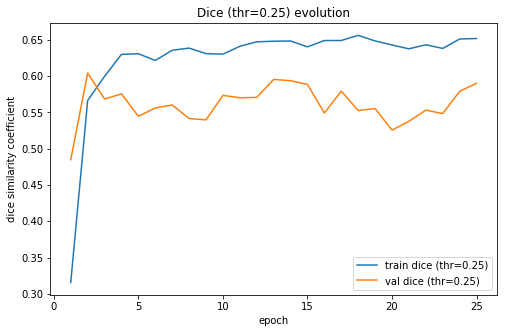

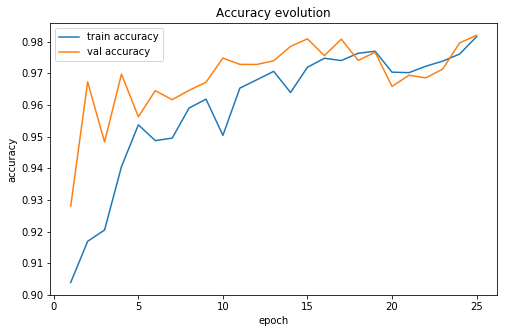

In [11]:
plot_train_val(model.history.history['loss'],
               model.history.history['val_loss'],
               fig_title='Loss',
               y_label='binary cross entropy')

plot_train_val(model.history.history['tf_jaccard'],
               model.history.history['val_tf_jaccard'],
               fig_title=f'IoU (thr={config.PRED_THR})',
               y_label='intersection over union')

plot_train_val(model.history.history['tf_dice'],
               model.history.history['val_tf_dice'],
               fig_title=f'Dice (thr={config.PRED_THR})',
               y_label='dice similarity coefficient')

plot_train_val(model.history.history['acc'],
               model.history.history['val_acc'],
               fig_title='Accuracy',
               y_label='accuracy')

## 5. Make some predictions with the model

In [12]:
best_model = unet(input_shape=config.INPUT_SHAPE,
                  pretrained_weights=f'{CHECKPOINTS_PATH}/unet_icoseg_test.hdf5')

In [13]:
%%time
test_img_batch = test_images[12:15]
test_mask_batch = test_masks[12:15]
train_img_batch = train_images[25:28]
train_mask_batch = train_masks[25:28]

test_pred_batch = best_model.predict(test_img_batch, batch_size=3)
train_pred_batch = best_model.predict(train_img_batch, batch_size=3)

CPU times: user 6.83 s, sys: 1.51 s, total: 8.34 s
Wall time: 8.33 s


dataset_split: test


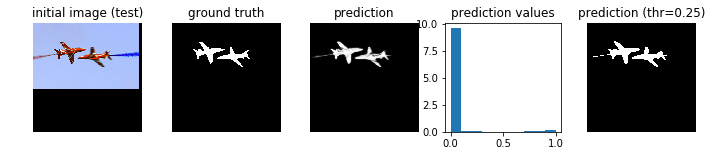

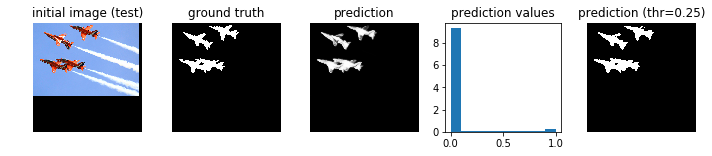

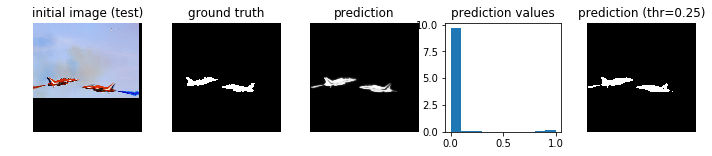

dataset_split: train


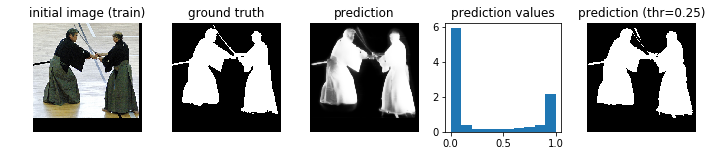

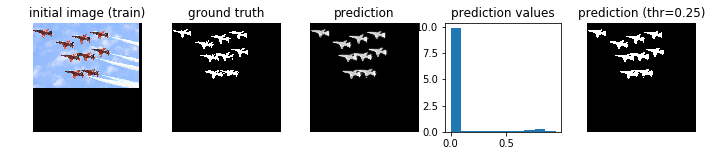

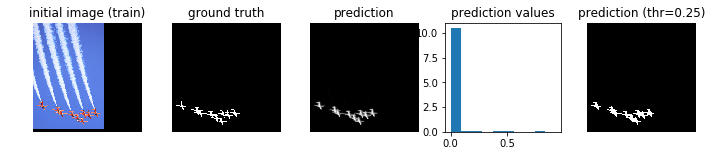

In [14]:
plot_image_mask_prediction(test_img_batch, test_mask_batch, test_pred_batch,
                           dataset_split='test', pred_thr=config.PRED_THR)
plot_image_mask_prediction(train_img_batch, train_mask_batch, train_pred_batch,
                           dataset_split='train', pred_thr=config.PRED_THR)

### 5. 1 Unseen image categories

In [15]:
img_names = ['19_Rainy.jpg', '20160524_GF1_00051.png', '20160524_GF2_00047.png']
print(PLAYGROUND_DATASET_PATH)
print(img_names)

../datasets/playground
['19_Rainy.jpg', '20160524_GF1_00051.png', '20160524_GF2_00047.png']


In [16]:
images = load_images_from_list(img_names, path=PLAYGROUND_DATASET_PATH)
print(images.shape, images.dtype, images.min(), images.max())

(3, 720, 1280, 3) uint8 0 255


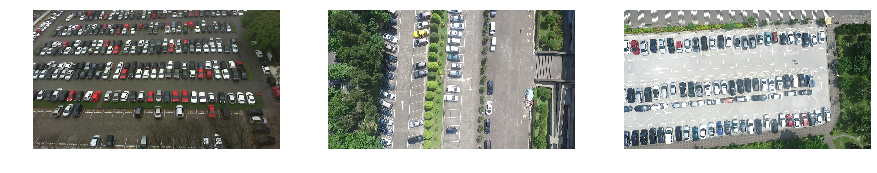

In [17]:
grid_vis(images, grid_rows=1, grid_cols=len(images))

patches
(2, 3, 512, 512, 3) float64 0.0 1.0
(2, 3, 512, 512) float64 3.990483055105187e-09 0.9992475509643555
img from patches
(720, 1280, 3) float64 0.0 1.0
(720, 1280) float64 2.993864836753346e-05 0.9992475509643555

patches
(2, 3, 512, 512, 3) float64 0.0 1.0
(2, 3, 512, 512) float64 3.9889305192275515e-09 0.9803587198257446
img from patches
(720, 1280, 3) float64 0.0 1.0
(720, 1280) float64 9.538916856399737e-07 0.9803587198257446

patches
(2, 3, 512, 512, 3) float64 0.0 1.0
(2, 3, 512, 512) float64 3.990483055105187e-09 0.9900746941566467
img from patches
(720, 1280, 3) float64 0.0 1.0
(720, 1280) float64 6.967318313400028e-07 0.9900746941566467



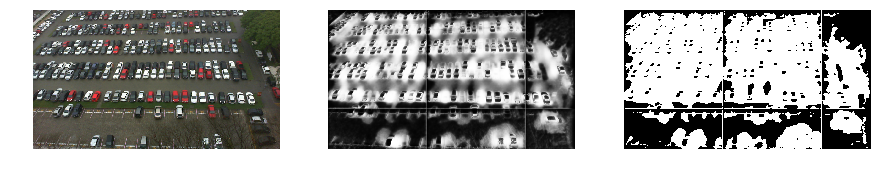

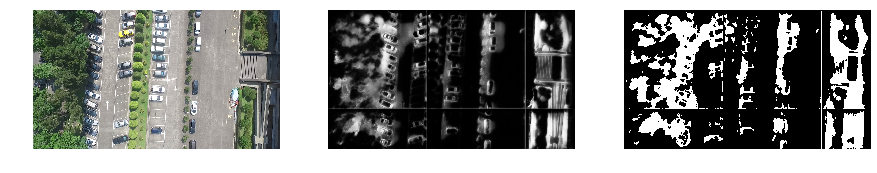

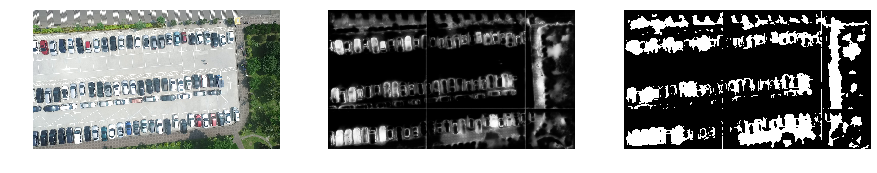

In [18]:
for img in images:
    img_patches = crop_image(img, patch_h=512, patch_w=512) / 255.
    pred_patches = np.zeros(img_patches.shape[:-1])
    
    for i in range(img_patches.shape[0]):
        for j in range(img_patches.shape[1]):
            pred_patches[i][j] = model.predict(img_patches[i][j][np.newaxis]).squeeze()
    
    print('patches')
    print(img_patches.shape, img_patches.dtype, img_patches.min(), img_patches.max())
    print(pred_patches.shape, pred_patches.dtype, pred_patches.min(), pred_patches.max())
    
    img_from_patches = merge_patches(img_patches, img_h=img.shape[0], img_w=img.shape[1])
    pred_from_patches = merge_patches(pred_patches, img_h=img.shape[0], img_w=img.shape[1])
    pred_from_patches_thresholded = (pred_from_patches > config.PRED_THR)
    grid_vis([img_from_patches, pred_from_patches, pred_from_patches_thresholded],
             grid_rows=1, grid_cols=3)
    
    print('img from patches')
    print(img_from_patches.shape, img_from_patches.dtype, img_from_patches.min(), img_from_patches.max())
    print(pred_from_patches.shape, pred_from_patches.dtype, pred_from_patches.min(), pred_from_patches.max())
    print()